# Transport of inertial particles in a periodic flow field

In [1]:
using Pkg
pkg"activate /Users/jeff/JuliaProjects/ViscousStreaming"

Activating environment at `~/JuliaProjects/ViscousStreaming/Project.toml`


In [2]:
using Revise

In [3]:
using ViscousStreaming

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/ViscousStreaming/UPKy8.ji for ViscousStreaming [47fb7046-13b0-40db-b6a6-74fa44cf0959]
└ @ Base loading.jl:1240


In [4]:
using LinearAlgebra

In [5]:
using JLD, FileIO

In [6]:
using Interpolations
using OrdinaryDiffEq
using DiffEqCallbacks # for manifold projection
using Statistics
import Statistics: mean

In [7]:
using LaTeXStrings
using Plots

clibrary(:colorbrewer)

:colorbrewer

In [8]:
using NamedColors

In [9]:
c_motion = colorant"Capri"
c_fixed = colorant"Black"
c_FullMR = colorant"Steel Blue"
c_AsympMR = colorant"purple" 
c_AvgMR = colorant"orange"
c_MixedMR = colorant"dark red"
c_Fluid = colorant"pinky purple"
c_AvgFluid = colorant"marine"
c_MixedFluid = colorant"Lucky"

### Set some of the basic parameters of the underlying fluid flow
These are only used for accessing the data set and for plotting. This stuff should be removed and simply loaded in.

Set oscillatory motion of the cylinder. This is only used for plotting purposes.

In [10]:
Re = 40.0
ϵ = 0.1
Ω = 1.0  # angular frequency
Ax1 = 1.0 # x amplitude (before scaling by ϵ)
ϕx1 = 0.0 # phase lead of x motion
Ay1 = 0.0 # y amplitude
ϕy1 = 0.0 # phase lead of y motion
basicoscil = RigidBodyMotions.RigidBodyMotion(RigidBodyMotions.Oscillation(Ω,Ax1,ϕx1,Ay1,ϕy1))

Tp = 2*π / Ω

6.283185307179586

Set the grid spacing and time step size for accessing the correct solution files

In [11]:
Δx = 0.02
Δt = min(π*0.5*Δx,π*0.5*Δx^2*Re)

0.025132741228718343

Create Cylinder and surrounding domain

In [12]:
nbody = 1
n = 150
body = Bodies.Circle(1.0,n)
b = deepcopy(body)
bmotion = deepcopy(body)

cent = (0.0,0.0)
α = 0.0
T = RigidTransform(cent,α)
T(b)

cent = (0.0+ϵ,0.0)
α = 0.0
T = RigidTransform(cent,α)
T(bmotion)

Circular body with 150 points and radius 1.0
   Current position: (0.1,0.0)
   Current angle (rad): 0.0


In [10]:
nbody = 2
n = 150
body = Bodies.Circle(1.0,n)
bL = deepcopy(body)
bR = deepcopy(body)
bRmotion = deepcopy(body)

cent = (-3.0,0.0)
α = 0.0
T = RigidTransform(cent,α)
T(bL)

cent = (3.0,0.0)
α = 0.0
T = RigidTransform(cent,α)
T(bR)

cent = (3.0-ϵ,0.0)
α = 0.0
T = RigidTransform(cent,α)
T(bRmotion)

bl = BodyList()
push!(bl,bL)
push!(bl,bR)

2-element Array{Body,1}:
 Circular body with 150 points and radius 1.0
   Current position: (-3.0,0.0)
   Current angle (rad): 0.0

 Circular body with 150 points and radius 1.0
   Current position: (3.0,0.0)
   Current angle (rad): 0.0
 

## Load data from CFD simulations

Some notes on the flow data: Currently, it is assumed that vorticities `w1` and `w2` in `data_history` are not scaled by $\epsilon$ or the grid spacing. However, `ux`, `uy`, `u1x` and `u1y` are scaled by $\epsilon$ and grid spacing. For example, `ux` represents the x component of $\epsilon \mathbf{u}_1 + \epsilon^2 \mathbf{u}_2$, and `u1y` the y component of $\epsilon \mathbf{u}_1$. 

#### Two-cylinder data

In [ ]:
datafile = "./CFD_data/2cylinder_steadyright_history_eps"*string(ϵ)*"_dx_"*string(Δx)*"_dt_"*string(Δt)*".jld"

#### One-cylinder data

In [15]:
datafile = "./CFD_data/1cylinder_steady_history_eps"*string(ϵ)*"_dx_"*string(Δx)*"_dt_"*string(Δt)*".jld"

"./CFD_data/1cylinder_steady_history_eps0.1_dx_0.02_dt_0.025132741228718343.jld"

#### Load it in

In [16]:
JLD.@load datafile data_history vel_history g Δt

4-element Array{Symbol,1}:
 :data_history
 :vel_history 
 :g           
 :Δt          

Set some shorthand names for the data

In [17]:
w1 = data_history[1]
w2 = data_history[2]
thist = data_history[5]
ux = vel_history[1]
uy = vel_history[2]
u1x = vel_history[3]
u1y = vel_history[4]
nothing

Set up some basic sizes

In [18]:
q̄ = Edges(Primal,size(g))
RangexuxCFD, RangeyuxCFD = coordinates(q̄.u, g)
RangexuyCFD, RangeyuyCFD = coordinates(q̄.v, g)
trangeCFD=Δt:Δt:2*π+Δt

0.025132741228718343:0.025132741228718343:6.308318048408304

## Set the inertial particle parameters

In [19]:
# Stokes number
τ = 0.1

# density ratio ρp/ρf
dratio = 0.95

# calculate beta
β = 3/(2*dratio+1)

p = InertialParameters(beta=β,tau=τ,epsilon=ϵ,Re=Re)

InertialParameters(1.0344827586206897, 0.1, 0.1, 40.0)

## Compute the full particle trajectory
Use small-Stokes number approximation for the particle velocity field

This is the full inertial particle velocity field:

In [20]:
vx, vy = inertial_velocity(ux,uy,ddt(ux)/Δt,ddt(uy)/Δt,w1+ϵ*w2,g,Δt,p,cflag=true);

Create an interpolated form (both spatially and temporally) for advancing particle trajectories in.

In [21]:
vxipt3 = interpolated_history(vx,RangexuxCFD,RangeyuxCFD,trangeCFD)
vyipt3 = interpolated_history(vy,RangexuyCFD,RangeyuyCFD,trangeCFD);

Transform the velocity history into a form conducive for interpolation

In [22]:
function vfcn(dR,R,p,t)
    
   dR[1] = vxipt3(R[1],R[2],t)
   dR[2] = vyipt3(R[1],R[2],t)
    
   return dR 
end

vfcn (generic function with 1 method)

In [23]:
X₀ = (2.0,2.0)
Tmax = 25000Tp

157079.63267948964

In [24]:
solFull = compute_trajectory(vfcn,X₀,Tmax,Δt);

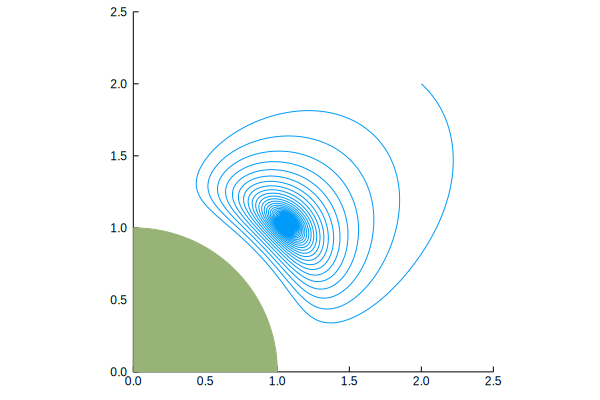

In [25]:
plot(solFull[1,1:250:end],solFull[2,1:250:end],ratio=1,xlim=(0,2.5),ylim=(0,2.5))
plot!(body)

### Construct the Lagrangian mean inertial particle velocity field

Compute $\epsilon \mathbf{v}_1$:

In [28]:
v1x, v1y = inertial_velocity(u1x,u1y,ddt(u1x)/Δt,ddt(u1y)/Δt,w1,g,Δt,p);

Compute $\epsilon \mathbf{v}_1 + \epsilon^2 \mathbf{v}_2$:

In [29]:
v12x, v12y = inertial_velocity(ux,uy,u1x,u1y,ddt(ux)/Δt,ddt(uy)/Δt,ddt(u1x)/Δt,ddt(u1y)/Δt,w1,g,Δt,p,cflag=true);

#### Perform Reynolds decomposition of the velocity and first-order velocity

In [30]:
v̄ = Edges(Primal,q̄)
ṽx = deepcopy(v12x)
ṽy = deepcopy(v12y)
reynolds_decomposition!(v̄,ṽx,ṽy,1:length(thist));

In [31]:
v̄1 = Edges(Primal,q̄)
ṽ1x = deepcopy(v1x)
ṽ1y = deepcopy(v1y)
reynolds_decomposition!(v̄1,ṽ1x,ṽ1y,1:length(thist));

#### Now compute the Stokes drift, $\xi\cdot\nabla v$, and the Lagrangian mean velocity, $\overline{v}^L = \overline{v} + \overline{\xi\cdot\nabla v}$

In [32]:
v̄d = stokes_drift(ṽ1x,ṽ1y,trangeCFD,Δt,g);

In [33]:
v̄L = v̄ + v̄d;

In [34]:
@save "./CFD_data/1cylinder_steady_inertvel_eps"*string(ϵ)*"_dx_"*string(Δx)*"_dt_"*string(Δt)*".jld" v1x v1y v12x v12y v̄L thist g Δt

### Or, load in the velocities from file

In [27]:
@load "./CFD_data/1cylinder_steady_inertvel_eps"*string(ϵ)*"_dx_"*string(Δx)*"_dt_"*string(Δt)*".jld" v1x v1y v12x v12y v̄L thist g Δt

7-element Array{Symbol,1}:
 :v1x  
 :v1y  
 :v12x 
 :v12y 
 :thist
 :g    
 :Δt   

#### Create a continuous spatial function of mean Lagrangian velocity

In [35]:
v̄Luxy = CubicSplineInterpolation((RangexuxCFD, RangeyuxCFD),v̄L.u, extrapolation_bc = (Flat(),Flat()))
v̄Lvxy = CubicSplineInterpolation((RangexuyCFD, RangeyuyCFD),v̄L.v, extrapolation_bc = (Flat(),Flat()))
nothing

## Now integrate mean particle trajectories

In [36]:
function v̄Lfcn(dR,R,p,t)
    
   dR[1] = v̄Luxy(R[1],R[2])
   dR[2] = v̄Lvxy(R[1],R[2])
    
   return dR 
end

v̄Lfcn (generic function with 1 method)

In [37]:
X₀ = (2.0,2.0)
Tmax = 25000Tp

157079.63267948964

In [44]:
solL = compute_trajectory(v̄Lfcn,X₀,Tmax,Tp,body,ϵ=p.ϵ);

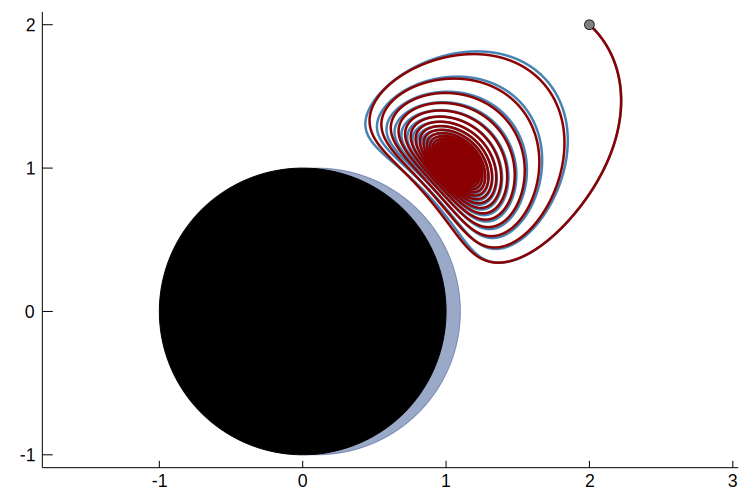

In [45]:
#ps = plot(xg,yg,ψ̄₂d,ratio=1,colorbar=false,xlim=(0,6),ylim=(0,4),
#    levels=range(-0.12,-0.011,length=10),clim=(-0.12,-0.011),color=:lightgrey)
plot(solFull[1,1:250:end],solFull[2,1:250:end],ratio=1,linecolor=c_FullMR,linewidth=2.5)
plot!(solL[1,:],solL[2,:],ratio=1,legend=false,
    linewidth=2.5,linecolor=c_MixedMR)
plot!(bmotion,fillcolor=c_motion,linecolor=c_motion, opacity =0.4)
plot!(b,fillcolor=c_fixed,linecolor=c_fixed,
#    background_color=:transparent,
    xtickfont = font(12),
#     xlabel ="x/R",
#     guidefont = font(8,"Courier"),
# ylabel = "y/R",
    ytickfont = font(12),
    legend =false, size = (750,500))
scatter!([X₀[1]],[X₀[2]],marker = 5, color = :grey)

In [672]:
#savefig(ps,"Comparison_InertialTraj_1030.pdf")
savefig(ps,"Comparison_InertialTraj_1030_expand.pdf")

In [669]:
#plot!(xg,yg,ψ̄₂d,ratio=1,colorbar=false,xlim=(0,2.5),ylim=(0,2.5),
#    levels=range(-0.12,-0.011,length=10),clim=(-0.12,-0.011),color=:blues)
ps = plot(solFull[1,1:5:2100001],solFull[2,1:5:2100001],ratio=1,linecolor=c_FullMR,linewidth=0.5)
plot!(solL[1,1:1681],solL[2,1:1681],ratio=1,xlim=(0,4),ylim=(0,4),legend=false,
    linewidth=2.5,linecolor=c_MixedMR)
plot!(bodymotion,fillcolor=c_motion,linecolor=c_motion, opacity =0.4)
plot!(body,fillcolor=c_fixed,linecolor=c_fixed,
#    background_color=:transparent,
    xtickfont = font(12),
#     xlabel ="x/R",
#     guidefont = font(8,"Courier"),
# ylabel = "y/R",
    ytickfont = font(12),
    legend =false, size = (500,500))
scatter!([X₀[1]],[X₀[2]],marker = 5, color = :grey)

In [670]:
savefig(ps,"Comparison_FullInertialTraj_1030.pdf")

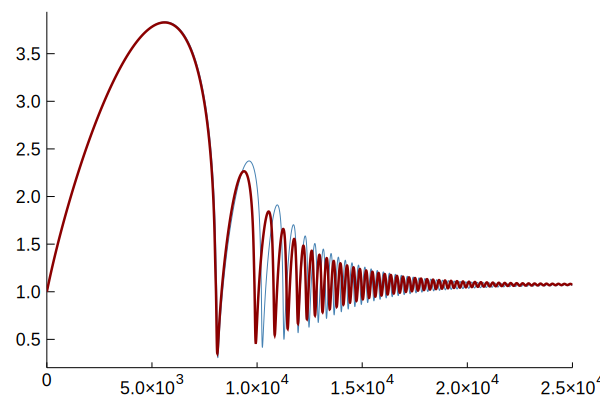

In [665]:
ps = plot(solFull.t[1:250:end]/T,solFull[1,1:250:end],linecolor=c_FullMR,linewidth=1)
plot!(solL.t/T,solL[1,:],legend=false,
    linewidth=2.5,linecolor=c_MixedMR,xtickfont = font(12),ytickfont = font(12),xlim=(0,25000))

In [666]:
savefig(ps,"Comparison_FullInertialTrajX_1030.pdf")

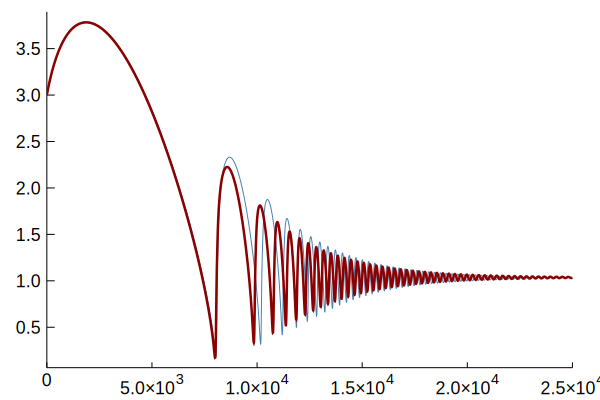

In [667]:
ps = plot(solFull.t[1:250:end]/T,solFull[2,1:250:end],linecolor=c_FullMR,linewidth=1)
plot!(solL.t/T,solL[2,:],legend=false,
    linewidth=2.5,linecolor=c_MixedMR,xtickfont = font(12),ytickfont = font(12),xlim=(0,25000))

In [668]:
savefig(ps,"Comparison_FullInertialTrajY_1030.pdf")